In [59]:
import uproot
import numpy as np
import torch
from collections import defaultdict
from util import get_layer, theta_func, calculate_num_pixels_z_dependence,create_layer_map
import matplotlib.pyplot as plot

layer_map, super_layer_map = create_layer_map()
x_hit_pos = []
layer_list = []
def process_root_file(file_path):
    print("began processing")
    with uproot.open(file_path) as file:
        tree = file["events/HcalBarrelHits"]
        
        z_pos = tree["HcalBarrelHits.position.z"].array(library="np")
        x_pos = tree["HcalBarrelHits.position.x"].array(library="np")
        energy = tree["HcalBarrelHits.EDep"].array(library="np")
        momentum_x = tree["HcalBarrelHits.momentum.x"].array(library="np")
        momentum_y = tree["HcalBarrelHits.momentum.y"].array(library="np")
        momentum_z = tree["HcalBarrelHits.momentum.z"].array(library="np")
        hit_time = tree["HcalBarrelHits.time"].array(library="np")
        print("finished loading branches")
        processed_data = defaultdict(dict)
        
        for event_idx in range(len(z_pos)):
            energy_per_layer = defaultdict(float)
            first_hit_per_layer = {}
            
            # First pass: collect first hit data and calculate energy per layer
            for hit_idx in range(len(z_pos[event_idx])):
                z = z_pos[event_idx][hit_idx]
                x = x_pos[event_idx][hit_idx]
                x_hit_pos.append(x)
                e = energy[event_idx][hit_idx]
                momentum = (momentum_x[event_idx][hit_idx],
                            momentum_y[event_idx][hit_idx],
                            momentum_z[event_idx][hit_idx])
                momentum_mag = np.linalg.norm(momentum)
                theta = theta_func(momentum_x[event_idx][hit_idx],momentum_y[event_idx][hit_idx],momentum_z[event_idx][hit_idx])
                layer = get_layer(x)
                if(layer == 0):
                    print(f"x: {x}\t|\tlayer: {layer}")
                    return
                layer_list.append(layer)
                
                energy_per_layer[layer] += e
                
                if layer not in first_hit_per_layer:
                    first_hit_per_layer[layer] = {
                        "z_pos": z,
                        "x_pos": x,
                        "energy": e,
                        "momentum": momentum_mag,
                        "theta": theta,
                        "time": hit_time[event_idx][hit_idx]
                    }
            
            # Second pass: process first hit with total layer energy
            for layer, hit_data in first_hit_per_layer.items():
                layer_energy = energy_per_layer[layer]
                num_pixels = calculate_num_pixels_z_dependence(layer_energy,hit_data["z_pos"])
                hit_data["num_pixels"] = num_pixels
                hit_data["layer_energy"] = layer_energy  # Store total layer energy for reference
                processed_data[event_idx][layer] = hit_data
    print("finished processing")
    return processed_data

def prepare_nn_input(processed_data, normalizing_flow):
    nn_input = defaultdict(lambda: defaultdict(list))
    nn_output = defaultdict(lambda: defaultdict(list))
    
    for event_idx, event_data in processed_data.items():
        for layer, hit_data in event_data.items():
            context = torch.tensor([hit_data['z_pos'], hit_data['theta'], hit_data['momentum']], dtype=torch.float32)
            context = context.repeat(hit_data['num_pixels'], 1)  # Repeat context for each pixel
            
            # Generate samples for all pixels in the layer
            with torch.no_grad():
                samples = normalizing_flow.sample(num_samples=1, context=context).squeeze()
            
            # Add the sampled times to the original time
            adjusted_times = samples + hit_data['time']
            
            # Sort all pixels by adjusted time and take the lowest 10
            sorted_indices = torch.argsort(adjusted_times)[:10]
            
            nn_input[event_idx][layer] = adjusted_times[sorted_indices]
            nn_output[event_idx][layer] = torch.full((10,), hit_data['momentum'], dtype=torch.float32)
    
    return nn_input, nn_output

def prepare_prediction_input(nn_input, nn_output):
    prediction_input = []
    prediction_output = []
    
    for event_idx in nn_input.keys():
        event_input = []
        event_output = []
        
        for layer in sorted(nn_input[event_idx].keys()):
            layer_times = nn_input[event_idx][layer]
            layer_momenta = nn_output[event_idx][layer]
            
            # Pad or truncate to exactly 10 times per layer
            if len(layer_times) < 10:
                padding = torch.full((10 - len(layer_times),), float('inf'))
                layer_times = torch.cat([layer_times, padding])
            
            event_input.append(layer_times)
            event_output.append(layer_momenta.mean())  # Using mean momentum as the target
        
        prediction_input.append(torch.stack(event_input))
        prediction_output.append(torch.stack(event_output))
    
    return torch.stack(prediction_input), torch.stack(prediction_output)

# Example usage:
# def calculate_theta(z, x):
#     return np.arctan2(x, z)

# def calculate_num_pixels(z, x, layer_energy):
#     # Implement your logic to calculate the number of pixels for a hit
#     # using z, x positions and the total energy deposited in the layer
#     pass
pref = "/hpc/group/vossenlab/rck32/"
processed_data = process_root_file(pref + "eic/work_eic/root_files/August_28/sector_scint/run_1/run_1_n_0_8_10GeV_theta_90_5kevents.edm4hep.root")
# nn_input, nn_output = prepare_nn_input(processed_data, normalizing_flow_model)
# prediction_input, prediction_output = prepare_prediction_input(nn_input, nn_output)

began processing
finished loading branches
x: 1835.1270999179642	|	layer: 0


In [54]:
processed_data[0].keys()

dict_keys([12, 11, 15, 16, 17, 19, 20, 13, 21, 18, 22, 23, 14, 10, 24, 25, 26, 27, 6, 9, 8, 4, 5, 7, 3, 2])

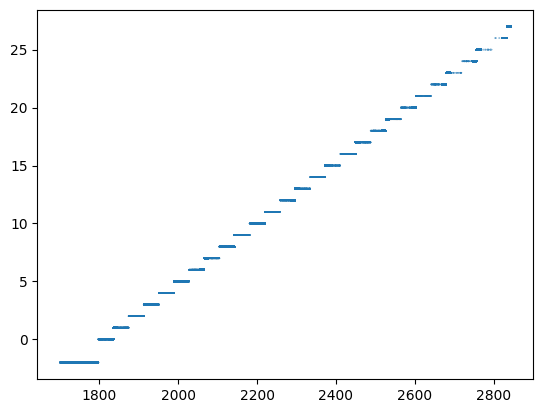

In [45]:
x_arr = np.array(x_hit_pos)
x_arr_cut = x_arr[x_arr > 1700]
layer_arr_cut = layer_arr[x_arr > 1700]
layer_arr = np.array(layer_list)
sizes = np.ones(len(x_arr_cut)) * 0.05
plot.scatter(x_arr_cut,layer_arr_cut,sizes);

In [42]:
len(x_arr)

1964258

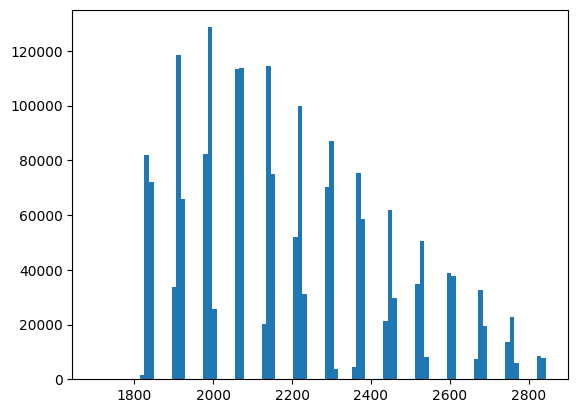

In [31]:
plot.hist(x_arr[x_arr > 1700],bins = 100);